In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yaml
import os
import glob
import re
from matplotlib import pyplot as plt

import arviz as az

os.chdir('/home/jp4474/latent-abc-smc')

from models import TSMVAE
from lightning_module import PreTrainLightning
from systems import MZB
from dataset import MZBDataset, MZBDatasetV2

In [26]:
folder_name = "/home/jp4474/latent-abc-smc/mzb_d128_ed64_6_4_vae_mask_0.5_beta_0.001"
config = yaml.safe_load(open(f"{folder_name}/config.yaml"))
model = TSMVAE(**config["model"]["params"], tokenize="linear")

pretrain_model_path = [f for f in os.listdir(folder_name) if f.endswith(".ckpt") and "TSMVAE" in f][0]
pl_model = PreTrainLightning.load_from_checkpoint(os.path.join(folder_name, pretrain_model_path), model = model)

print("Successfully loaded model")

Successfully loaded model


In [27]:
observational_data = np.load("/home/jp4474/latent-abc-smc/data/mzb_data.npz")

In [28]:
observational_data

NpzFile '/home/jp4474/latent-abc-smc/data/mzb_data.npz' with keys: obs_data, scaled_obs_data, obs_scale

In [29]:
mzb_abc = MZB(observational_data = observational_data['obs_data'])
mzb_abc.update_model(pl_model)

INFO:latent_abc_smc:Initializing LatentABCSMC class
INFO:latent_abc_smc:Initialization complete
INFO:latent_abc_smc:LatentABCSMC class initialized with the following parameters:
INFO:latent_abc_smc:num_parameters: 5
INFO:latent_abc_smc:lower_bounds: [ 0.  10.  -0.2 -7.4 -6.4]
INFO:latent_abc_smc:upper_bounds: [ 1.  18.   0.4 -2.6 -1.6]
INFO:latent_abc_smc:t0: 40
INFO:latent_abc_smc:tmax: 732
INFO:latent_abc_smc:time_space: [ 59  69  76  88  95 102 108 109 113 119 122 124 141 156 158 183 212 217
 219 235 261 270 289 291 306 442 524 563 566 731]
INFO:latent_abc_smc:pooling_method: cls
INFO:latent_abc_smc:metric: cosine
INFO:latent_abc_smc:Model updated


In [30]:
train_dataset = MZBDataset("data", "train")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=768, shuffle=True)

In [31]:
latent_representations = []
params = []
for batch in train_dataloader:
    x, y = batch
    y = y.to(pl_model.device).float()
    with torch.no_grad():
        z = mzb_abc.get_latent(y)
        latent_representations.append(z)
    params.append(x)

latent_representations = np.concatenate(latent_representations, axis=0)
params = np.concatenate(params, axis=0)

In [32]:
params.shape

(36614, 5)

In [33]:
df = pd.DataFrame(latent_representations)
# append two columns
df["a"] = params[:, 0]
df["b"] = params[:, 1]
df["c"] = params[:, 2]
df["d"] = params[:, 3]
df["e"] = params[:, 4]

In [34]:
df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,a,b,c,d,e
0,-0.372090,-0.178986,0.103323,0.091252,0.484603,0.299236,0.185623,0.681893,0.073487,-0.227511,...,0.289038,0.148904,0.074987,0.430260,0.447393,0.180844,10.824780,0.373690,-3.140644,-1.752603
1,0.135547,0.146820,0.153281,0.205956,0.106141,-0.079811,0.385433,-0.087949,0.272029,-0.269509,...,-0.121019,0.066996,0.062992,0.403147,-0.078065,0.263516,12.331161,-0.088826,-4.402894,-2.227022
2,-0.537193,-0.236094,0.302539,0.095437,0.466942,0.212713,-0.142723,0.882571,-0.259217,-0.157534,...,0.356765,-0.061428,-0.205841,0.556312,0.688078,0.056414,16.816975,0.317620,-3.872260,-1.924735
3,-0.129871,0.017973,0.206350,0.206288,0.170223,-0.008248,0.122637,0.281207,0.055799,-0.184164,...,0.123553,-0.024770,-0.088608,0.463402,0.239051,0.201226,14.825740,0.084929,-6.426971,-2.092561
4,-0.320415,-0.037682,0.331515,0.244446,0.138394,-0.075240,-0.175407,0.515638,-0.187658,-0.100019,...,0.302271,-0.186593,-0.319866,0.526018,0.481163,0.032723,13.151484,-0.027253,-3.733956,-2.627939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36609,-0.099770,0.033128,0.248839,0.189920,0.161107,-0.034963,0.112786,0.239394,0.019904,-0.191911,...,0.056833,-0.054673,-0.112604,0.491089,0.220795,0.151084,15.628100,0.010707,-4.267058,-2.275626
36610,-0.176495,-0.008163,0.300084,0.170194,0.195175,-0.020091,0.022583,0.345162,-0.084046,-0.176289,...,0.081531,-0.101792,-0.177442,0.534490,0.317188,0.147636,16.728712,0.282610,-5.431346,-2.185513
36611,0.324086,0.223605,0.065238,0.134462,0.237217,-0.038812,0.782063,-0.334134,0.542561,-0.443491,...,-0.410876,0.289629,0.317544,0.302248,-0.387883,0.547878,15.116909,0.112398,-4.221611,-1.921185
36612,-0.021845,0.005507,0.098790,0.087075,0.369626,0.157213,0.463545,0.194613,0.279265,-0.322280,...,-0.072071,0.195994,0.196896,0.403373,0.060981,0.499028,17.872322,0.018987,-5.858166,-1.647938


In [35]:
obs_data = observational_data['obs_data']
scaled_obs_data = mzb_abc.preprocess(obs_data)

In [36]:
torch_scaled_obs_data = torch.tensor(scaled_obs_data).to(pl_model.device).float().unsqueeze(0)
encoded_obs_data = mzb_abc.get_latent(torch_scaled_obs_data)[0]
mzb_abc.encoded_observational_data = encoded_obs_data

In [37]:
df['similarity'] = df.apply(
    lambda row: mzb_abc.calculate_distance(row[:64].values), axis=1
)

In [38]:
df = df.sort_values(by='similarity', ascending=True)

In [39]:
df.head(100).mean()[-7:]

63            -0.039385
a              0.012299
b             15.139495
c              0.126338
d             -5.412776
e             -4.496685
similarity     0.031494
dtype: float64

In [40]:
simulated_np, status = mzb_abc.simulate(particles[-1].mean(0))
#simulated_np, status = mzb_abc.simulate(np.array([0.08235591, 17.3881736 ,  0.09616237, -7,  2.3, -5.38346913]))
#simulated_np_scaled = simulated_np/np.mean(np.abs(observational_data['obs_data']), axis = 0)

simulated_np_scaled = mzb_abc.preprocess(simulated_np)

NameError: name 'particles' is not defined

In [ ]:
# np.mean(np.abs(simulated_np), axis = 0), np.mean(np.abs(observational_data['obs_data']), axis = 0)

In [41]:
raw_np_scaled = scaled_obs_data

In [42]:
with torch.no_grad():
    recon_loss, _, _, _, reconstruction = pl_model(torch_scaled_obs_data)
    reconstruction = reconstruction.squeeze(0).cpu().numpy()

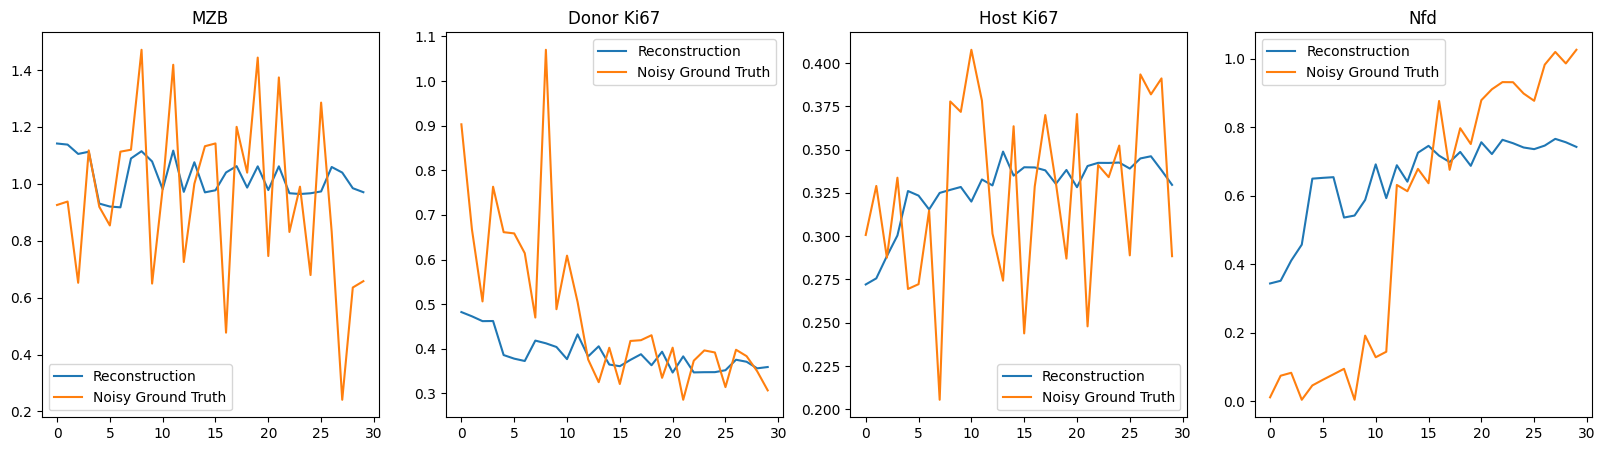

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
titles = ["MZB", "Donor Ki67", "Host Ki67", "Nfd"]
for i in range(4):
    ax[i].plot(reconstruction[:, i], label='Reconstruction')
    #ax[i].plot(simulated_np_scaled[:, i], label='Inferred')
    ax[i].plot(raw_np_scaled[:, i], label='Noisy Ground Truth')
    ax[i].legend()
    ax[i].set_title(titles[i])

In [44]:
def inverse_transform(x, scale):
    mzb, donor_ki67, host_ki67, nfd = x[:, 0], x[:, 1], x[:, 2], x[:, 3]

    mzb = np.exp(mzb*15) - 1e-8
    donor_ki67 = np.sin(donor_ki67) ** 2
    host_ki67 = np.sin(host_ki67) ** 2
    nfd = nfd

    x = np.stack([mzb, donor_ki67, host_ki67, nfd], axis=1)
    return x 

In [45]:
rescaled_reconstruction = inverse_transform(reconstruction, obs_data.mean(0)[0])

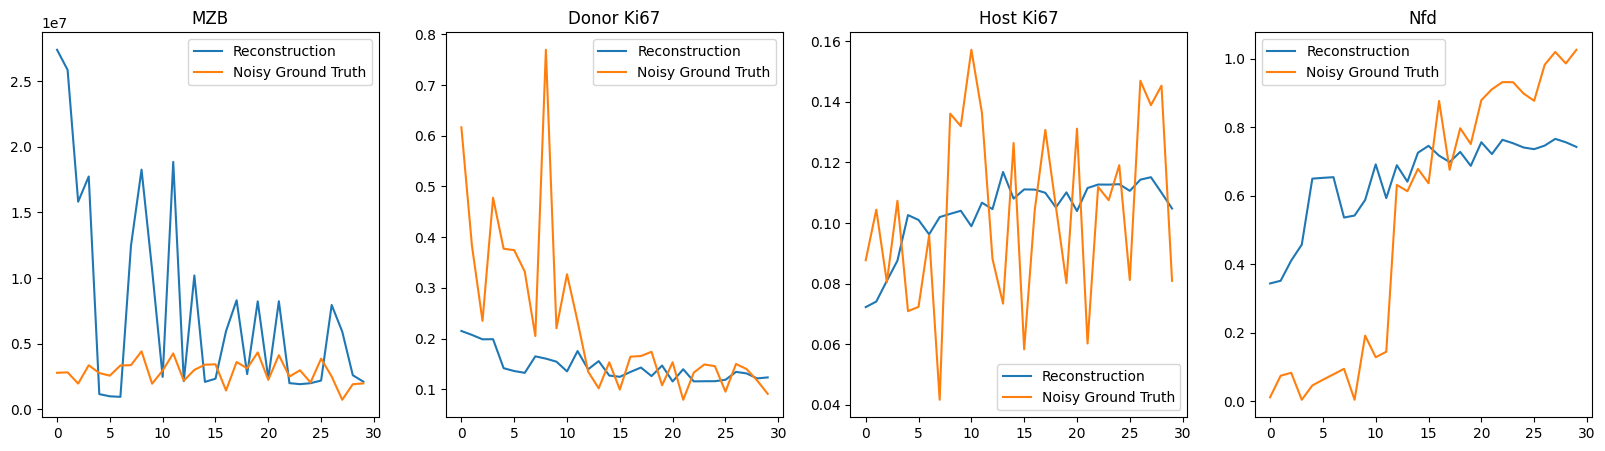

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].plot(rescaled_reconstruction[:, i], label='Reconstruction')
    #ax[i].plot(simulated_np[:, i], label='Inferred')
    ax[i].plot(observational_data['obs_data'][:, i], label='Noisy Ground Truth')
    ax[i].legend()
    ax[i].set_title(titles[i])

In [47]:
# torch.full((1,), 0)[0],
# log_sigma = torch.nn.Parameter(torch.full((1,), 0, dtype=torch.float)[0], requires_grad=True)

In [48]:
mzb_abc.pooling_method = "cls"
mzb_abc.metric = "cosine"
mzb_abc.encoded_observational_data.shape
particles, weights = mzb_abc.run(tolerance_levels=[0.3, 0.2, 0.1, 0.07, 0.03], num_particles=1000, sigma=0.1)

INFO:latent_abc_smc:Tolerance levels: [0.3, 0.2, 0.1, 0.07, 0.03]
INFO:latent_abc_smc:Starting ABC SMC run
INFO:latent_abc_smc:Generation 1 started
  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 6/1000 [00:06<17:56,  1.08s/it]


KeyboardInterrupt: 

In [ ]:
az.style.use("arviz-doc")

var_names = [r'$\phi$', r'$log(y_0)$', r'$\kappa_0$', r'$log(\rho)$', r'$\beta$', r'$log(\delta)$']

In [ ]:
#coords = {"school": ["Choate"]}

inference_data = az.convert_to_inference_data(
    particles,
    weights=weights,
    coords={"variable": var_names},  # Assign variable names
    dims={"x": ["variable"]}  # Ensure correct dimension labeling
)
axes = az.plot_posterior(
    inference_data
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("MZB Cell Dynamics Posterior Inference")

plt.show()

In [ ]:
mzb_abc.pooling_method = "all"
mzb_abc.metric = "bertscore"

torch_scaled_obs_data = torch.tensor(scaled_obs_data).to(pl_model.device).float().unsqueeze(0)
encoded_obs_data = mzb_abc.get_latent(torch_scaled_obs_data)[0]
mzb_abc.encoded_observational_data = encoded_obs_data

mzb_abc.encoded_observational_data.shape
particles_1, weights_1 = mzb_abc.run(tolerance_levels=[0.3, 0.2, 0.1, 0.07, 0.03], num_particles=1000, sigma=0.1)

In [ ]:
#coords = {"school": ["Choate"]}

inference_data = az.convert_to_inference_data(
    particles_1,
    weights=weights_1,
    coords={"variable": var_names},  # Assign variable names
    dims={"x": ["variable"]}  # Ensure correct dimension labeling
)
axes = az.plot_posterior(
    inference_data
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("MZB Cell Dynamics Posterior Inference")

plt.show()

In [ ]:
np.savez("mzb_abc.npz", particles=particles, weights=weights, particles_1=particles_1, weights_1=weights_1)

In [ ]:
mzb_abc.pooling_method = "all"
mzb_abc.metric = "bertscore"

torch_scaled_obs_data = torch.tensor(scaled_obs_data).to(pl_model.device).float().unsqueeze(0)
encoded_obs_data = mzb_abc.get_latent(torch_scaled_obs_data)[0]
mzb_abc.encoded_observational_data = encoded_obs_data

mzb_abc.encoded_observational_data.shape
particles, weights = mzb_abc.run(tolerance_levels=[0.3, 0.2, 0.1, 0.07, 0.03], num_particles=1000, sigma=0.1)

In [ ]:
mzb_abc.pooling_method = "mean"
mzb_abc.metric = "cosine"

torch_scaled_obs_data = torch.tensor(scaled_obs_data).to(pl_model.device).float().unsqueeze(0)
encoded_obs_data = mzb_abc.get_latent(torch_scaled_obs_data)[0]
mzb_abc.encoded_observational_data = encoded_obs_data

mzb_abc.encoded_observational_data.shape
particles, weights = mzb_abc.run(tolerance_levels=[0.3, 0.2, 0.1, 0.07, 0.03], num_particles=1000, sigma=0.1)

In [ ]:
# Save each subplot as a separate image (e.g., PNG or GIF)
for i in range(5):
    fig, ax = plt.subplots(1, 6, figsize=(20, 10))
    
    # Plot histograms for Beta and Alpha
    ax[0].hist(mzb_abc.particles[i][:, 0], bins=20, alpha=0.7, label="Posterior")
    ax[1].hist(mzb_abc.particles[i][:, 1], bins=20, alpha=0.7, label="Posterior")
    ax[2].hist(mzb_abc.particles[i][:, 2], bins=20, alpha=0.7, label="Posterior")
    ax[3].hist(mzb_abc.particles[i][:, 3], bins=20, alpha=0.7, label="Posterior")
    ax[4].hist(mzb_abc.particles[i][:, 4], bins=20, alpha=0.7, label="Posterior")
    ax[5].hist(mzb_abc.particles[i][:, 5], bins=20, alpha=0.7, label="Posterior")

    # phi, y0_Log, kappa_0, rho_Log, beta, delta_Log
    ax[0].set_title(r'$\phi$')
    ax[1].set_title(r'$log (y_0)$')
    ax[2].set_title(r'$\kappa_0$')
    ax[3].set_title(r'$log(\rho)$')
    ax[4].set_title(r'$\beta$')
    ax[5].set_title(r'$log(\delta)$')

    ax[0].axvline(x=mzb_abc.particles[i][:, 0].mean(), color='g', linestyle='--', label='Mean')
    ax[1].axvline(x=mzb_abc.particles[i][:, 1].mean(), color='g', linestyle='--', label='Mean')
    ax[2].axvline(x=mzb_abc.particles[i][:, 2].mean(), color='g', linestyle='--', label='Mean')
    ax[3].axvline(x=mzb_abc.particles[i][:, 3].mean(), color='g', linestyle='--', label='Mean')
    ax[4].axvline(x=mzb_abc.particles[i][:, 4].mean(), color='g', linestyle='--', label='Mean')
    ax[5].axvline(x=mzb_abc.particles[i][:, 5].mean(), color='g', linestyle='--', label='Mean')
        
    # Add legends to each subplot
    ax[0].legend()
    ax[1].legend()
    
    # Set a title for the entire figure
    fig.suptitle(f"Generation {i+1}")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()

# If you want to display the plots, you can do so before saving and closing them
plt.show()
plt.close()

In [ ]:
#np.savez("mzb_abc.npz", particles = mzb_abc.particles, weights = mzb_abc.weights)/